In [1]:
"""
This code makes diagnostic plots for raw and postprocessed WRF-Solar output
Postprocessing using the Kalman Filter is from Rafael Alvarenga's code (rafael.alvarenga@etu.univ-guyane.fr)
"""
import glob
import os
from file_func import *
from plotting import *
from __const__ import *



In [2]:
method='KF'
def kalmanfi(df, df_temp, nb_LTs):
    for nb_historical_days in [15]:
        
        timestep_enough_historical = (nb_historical_days*2)*nb_LTs  
        for t in tqdm(range(len(df_temp))):

            hour = df_temp.loc[t,'Time'].hour
            minutes = df_temp.loc[t,'Time'].minute

            if t >= timestep_enough_historical:
                # slice df_temp
                df_timestep = df_temp.loc[t-(nb_historical_days*nb_LTs)-(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices):t,:].copy()
            else:
                df_timestep = df_temp.loc[t:t+(nb_historical_days*nb_LTs)+(nb_historical_days*nb_LTs*recursive_calculation_covariance_matrices),:].copy()
                df_timestep = df_timestep[::-1].reset_index(drop=True)
            df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour == hour) & (df_timestep['Time'].dt.minute == minutes)]
            df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
            df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]

            if (len(df_timestep) == 0) & (len(df_timestep) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices) or (t not in df_timestep.index)):
                df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
                continue

            df_timestep = df_timestep.iloc[-(nb_historical_days+1)-(nb_historical_days*recursive_calculation_covariance_matrices):,:]
            df_timestep = df_timestep.reset_index(drop = True)

            # define prediction-bias variance matrix
            W = np.eye(len(predictors_vector))/1000

            # define measurement-bias variance matrix
            V = 0.01

            # define initial error covariance matrix
            Po = np.eye(len(predictors_vector))*5

            # define initial predicted bias
            xo = np.zeros(len(predictors_vector)).reshape(len(predictors_vector),1)

            measurement_GHI = []
            old_predicted_GHI = []
            improved_GHI = []
            ground_truths = []
            predicted_coefs = []

            for idx_i, i in enumerate(df_timestep.index):
                if recursive_calculation_covariance_matrices == True:
                    # --------------------------------------------
                    #  Calculate matrices of covariance of errors
                    # --------------------------------------------
                    if idx_i > nb_historical_days:
                        mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                        mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                        # old method
                        W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                        V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))

                        # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                        # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                        # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))

                # ----------------------------
                #           Predict
                # ----------------------------

                if idx_i == 0:
                    # predicted mean bias
                    x_pred = np.zeros_like(xo)
                    if add_noise_in_predictions == True:
                        x_pred = xo + np.random.multivariate_normal(mean=[0.5]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                    else:
                        x_pred = xo

                    # predicted bias covariance matrix
                    P = Po + W

                else:
                    # predicted mean bias
                    if add_noise_in_predictions == True:
                        x_pred = x_pred + np.random.multivariate_normal(mean=[0]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                    else:
                        x_pred = x_pred
                    #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors

                    # predicted bias covariance matrix
                    P = P + W

                # ----------------------------
                #           Update
                # ----------------------------

                # compute transition matrix based on the current predictors for this timestep
                H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
                H = np.asarray([1] + H).reshape(1, len(predictors_vector))
                if nonlinear_predictions == True:
                    H = [predictor**idx_predictor for idx_predictor, predictor in enumerate(H)]

                predicted_coefs.append(x_pred)
                improved_GHI.append(dot(H,x_pred))
                df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]

                # compute residual mean bias and residual bias covariance
                if add_noise_in_predictions == True:
                    new_measurement = df_timestep.loc[i,'Kc_GHI_obs'] + np.random.normal(loc = 0, scale = V)
                else:
                    new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
                residual_mean = new_measurement - dot(H,x_pred)
                residual_covariance = dot(H, P).dot(H.T) + V

                # compute Kalman gain based on the transition matrix and residual covariance
                K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
                K = np.nan_to_num(K, nan = 0)

                # update mean bias after incorporating measurements
                x_pred = x_pred + dot(K,residual_mean)

                # update bias covariance matrix after incorporating measurements
                #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
                P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)

                measurement_GHI.append(new_measurement)
                old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
                ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])

            # assign final prediction
            df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
        # calculate overall error metrics for this group of predictors
        df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

        df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
        df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

        rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
        mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
        mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
        mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])

        print('\n\n**************************')
        print(f'Predictors: {predictors_vector}')
        print(f'- RMS: {rms}')
        print(f'- MAE: {mae}')
        #print(f'- MSE: {mse}')
        print(f'- MBE: {mbe}')

        # assign post-processed timesteps to original dataframe
        copy = df_temp[['Time','GHI_pred_improved']]


        df_updated = df.merge(copy,how='outer',on="Time")
        df_updated['kf_obs'] = np.abs(df_updated['GHI_pred_improved'] - df_updated['ghi_obs'])
        df_updated['wrf_obs'] = np.abs(df_updated['ghi_mod'] - df_updated['ghi_obs'])

        #Kalman Filter Alone
        def kf_only(df):
            if ((df['GHI_pred_improved'] >= 0)):
                kf_only = df['GHI_pred_improved']
            else:
                kf_only = df['ghi_mod']
            return(kf_only)

        df_updated["GHI_pred_kf_only"] = df_updated.apply(kf_only, axis=1)

        #recording HITs and MISS for each LT or time of the day (Contingency Table)
        def lim(df):
            if ((df['GHI_pred_improved'] >= 0) & (df['kf_obs'] <= df['wrf_obs'])):
                lim = 'HIT' #by KF
            else:
                lim = 'MISS'
            return(lim)

        df_updated["flag_hit"] = df_updated.apply(lim, axis=1)

        table = df_updated.groupby(['LT','flag_hit']).agg({'flag_hit': ['count']}).droplevel(axis=1, level=0).reset_index()#.to_csv('summary.csv')
        table = pd.pivot_table(table, values='count', index=['LT'],columns=['flag_hit']).reset_index()#.to_csv('summary.csv')

        #this will be used to know whether the WRF or KF output is better for each LT or time of the day
        def hit(t):
            if ((t['HIT'] >= 0) & (t['HIT'] >= t['MISS'])):
                hit = 'KF'
            else:
                hit = 'WRF'
            return(hit)
        table["final"] = table.apply(hit, axis=1)

        df_updated = df_updated.merge(table,how='outer',on="LT")
        #depending on contingency table for each LT or time of the day 
        #use KF or WRF output
        def final_pred(df):
            if ((df['GHI_pred_improved'] >= 0) & (df['final'] == 'KF')):
                lim = df['GHI_pred_improved']
            else:
                lim = df['ghi_mod']
            return(lim)

        df_updated["GHI_pred_improved_fin"] = df_updated.apply(final_pred, axis=1)
        df_updated = df_updated.sort_values(by='Time').reset_index()
        #example for nb_historical_days=4
        #we are only correcting for 29 while 48 points are retained
        df_updated = df_updated[['Time',  'CMP22_Total_Solar', 'SPN1_Total_Solar',
               'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni',
               'MM', 'DD', 'HH', 'mm', 'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
               'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
               'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
               'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear', 'ghi_obs',
               'ens', 'domain', 'station_name', 'ghi_mod', 'YY',
               'Error_rel', 'Kc_GHI_pred', 'Kc_GHI_obs', 'Kc_obs_bias', 'LT',
               'GHI_pred_kf_only', 'GHI_pred_improved_fin']]
        # calculate overall error metrics for this group of predictors
        df_updated = df_updated.loc[~np.isnan(df_updated['GHI_pred_improved_fin'])]
        df_updated = df_updated.loc[~np.isnan(df_updated['ghi_obs'])]

        rms = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'], squared=False)
        mae = mean_absolute_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
        mse = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
        mbe = np.mean(df_updated['GHI_pred_improved_fin'] - df_updated['ghi_obs'])

        dir_path_recursive = f'{main_dir_path_recursive}/{ens}/{domain}/{station_name}/{nb_historical_days}_day_{method}'
        os.makedirs(dir_path_recursive, exist_ok=True)

        nb_historical_days = dir_path_recursive.split('/')[4]
        ensemble_member = dir_path_recursive.split('/')[1]

        df_updated.to_csv(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_df.csv")

        ts_all(res, df_updated,dir_path_recursive)
        scat_cloudy_all(res, df_updated,dir_path_recursive)
        scat_clear_all(res, df_updated,dir_path_recursive)

        '''scat_all(res, df_updated)
        ts_cut(res, df_updated)
        scat_cut(res, df_updated)
        scat_cloudy_cut(res, df_updated)
        scat_clear_cut(res, df_updated)'''



100%|███████████████████████████████████████| 2491/2491 [02:06<00:00, 19.70it/s]




**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 249.62498031236066
- MAE: 184.14190155826154
- MBE: 6.646729613676962


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 245.22258307913376
- MAE: 181.54399663314175
- MBE: 10.555209437660936


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 245.92037076524437
- MAE: 180.4366492145045
- MBE: -2.0264766244505146


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 243.20364432891841
- MAE: 180.96481978402616
- MBE: -0.9185937621294178


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 245.45437320223405
- MAE: 182.29763265966076
- MBE: 1.7257513614311306


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 241.6958374524954
- MAE: 180.8238328814529
- MBE: 4.979234049760925


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 245.26994412770063
- MAE: 183.85688913845544
- MBE: 1.9560296187222814


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:473: RuntimeWarning: More than 20 figures have been opened. Figure



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 248.07695590603612
- MAE: 183.7347717324338
- MBE: 3.775120660689392


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 241.27822025505733
- MAE: 179.36693580707504
- MBE: 1.066837162594073


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor



**************************
Predictors: ['Kc_GHI_pred', 'cossza', 'U10', 'V10', 'T2', 'Humi_rel']
- RMS: 239.16755385526832
- MAE: 178.18383306688028
- MBE: 2.2215730423927056


/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:184: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_Manila_ts_" + str(res) +"km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:394: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{dir_path_recursive}/{ensemble_member}_{domain}_{nb_historical_days}_all_cloudy_kf_Manila_scatplot_" + str((res)) + "km.png", dpi=500, frameon=False, facecolor='white', bbox_inches="tight")
/Users/apple/Desktop/Others/Python_Codes/wrf_solar/plotting.py:513: MatplotlibDeprecationWarning: savefig() got unexpected keywor

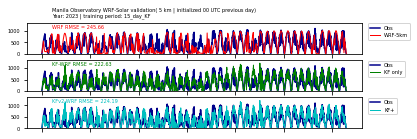

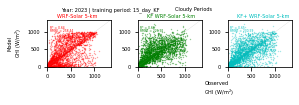

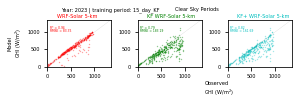

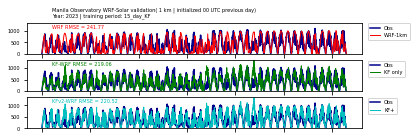

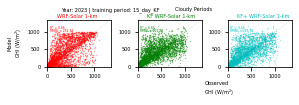

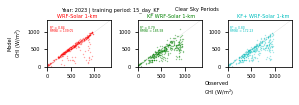

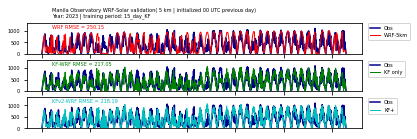

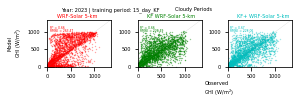

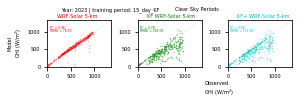

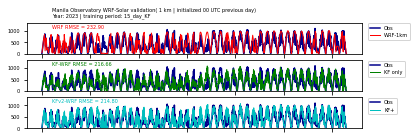

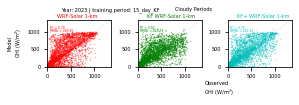

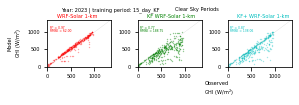

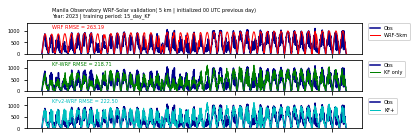

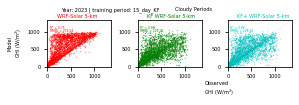

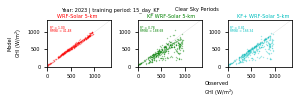

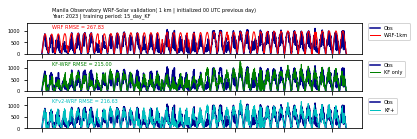

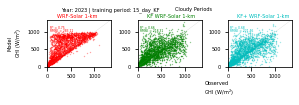

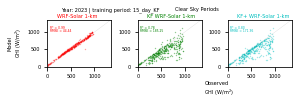

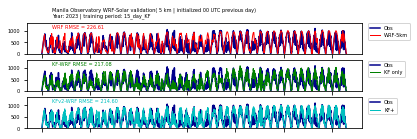

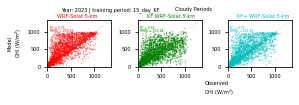

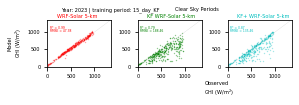

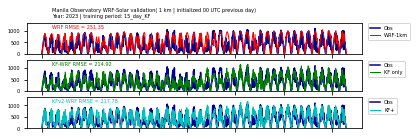

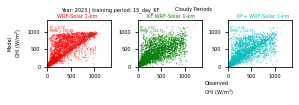

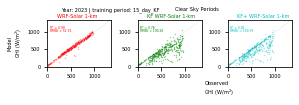

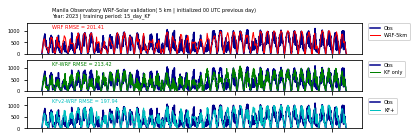

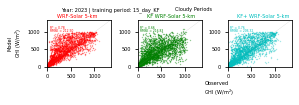

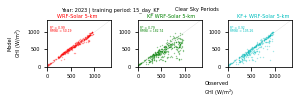

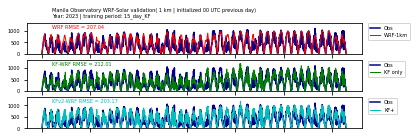

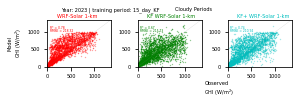

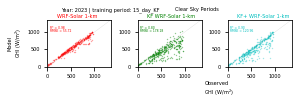

In [3]:
for ens in ['ens0','ens1','ens2','ens3','ensmean']:
    for domain in ['d01', 'd02']:
        
        if domain == 'd01':
            res = 5
        elif domain == 'd02':
            res = 1
        
        a = prep_input()[0]
        mod_ = prep_input()[1]

        os.makedirs(main_dir_path_recursive, exist_ok=True)

        df = prep_opt(mod_, a, ens, domain)[0]
        df_temp = prep_opt(mod_, a, ens, domain)[1]

        nb_LTs = len(np.unique(df_temp.LT))
        
        method='KF'
        
        kalmanfi(df, df_temp, nb_LTs)

In [ ]:
'''method= 'ANKF'
#for nb_historical_days in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
for nb_historical_days in [11]:
    #nb_historical_days = 11
    timestep_enough_historical = (nb_historical_days*2)*nb_LTs  
    for t in tqdm(range(len(df_temp))):

        # slice df to find analogs
        df_temp['date'] = df_temp['Time'].dt.date 
        
        # create hour column
        df_temp['TIME'] = df_temp['Time'].dt.time 

        # define variables to analyse when searching for analogs
        variables_to_search = ['Kc_GHI_pred','meanCC','T2']

        # define weights of each variable when searching for analogs
        weights_variables = {'Kc_GHI_pred': 0.7,
                             'T2': 0.3}
        
        df_timestep = df_temp.loc[:t,:].copy()
        df_timestep = df_timestep.loc[(df_timestep['Time'].dt.hour >= hour-1) & (df_timestep['Time'].dt.hour <= hour+1),:]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_GHI_pred'])]
        df_timestep = df_timestep.loc[~np.isnan(df_timestep['Kc_obs_bias'])]
   
        if (len(df_timestep) == 0) & (len(np.unique(df_timestep['date'])) <= nb_historical_days + (nb_historical_days*recursive_calculation_covariance_matrices)) or (t not in df_timestep.index):
            df_temp.loc[t,'Kc_GHI_pred_improved'] = np.nan  
            continue
        
        # ----------------------------
        #     Search for analogs
        # ----------------------------

        analogs = []
        for date in np.unique(df_timestep.Time.dt.date[:-1]):
            dist = 0
            for variable in variables_to_search:              
                analog = df_timestep.loc[df_timestep.Time.dt.date == date,['Time','TIME',variable]]
                try:
                    idx_right = analog.loc[(analog['Time'].dt.hour == hour) & (analog['Time'].dt.minute == minutes)].index[0]
                except:
                    dist = np.nan
                idx_ini = list(analog.index)[0]
                idx_fin = list(analog.index)[-1]
                
                current_prediction = df_temp.loc[(t-(idx_right-idx_ini)):(t+(idx_fin-idx_right)),['Time',variable]]
                current_prediction['TIME'] = current_prediction['Time'].dt.time
                analog = analog[['TIME',variable]].merge(current_prediction[['TIME',variable]], how='left', left_on='TIME',right_on='TIME')
                analog = analog.dropna()
                
                dist = dist + (weights_variables[variable]/df_timestep[variable].std()*np.sqrt(sum((analog.iloc[k,1] - analog.iloc[k,2])**2 for k in range(len(analog)))))
                
                del current_prediction
            analogs.append([date,dist])
        analogs = np.asarray(analogs)
        
        # remove NaN values
        analogs = analogs[np.argwhere(~np.isnan(analogs[:,1].astype(float)))[:,0]]
        
        # sort analogs according to distance
        analogs = analogs[np.argsort(analogs[:, 1])]
        
        # get dates of only the nb of analogs chosen previously
        analogs = list(analogs[:(nb_historical_days+(nb_historical_days*recursive_calculation_covariance_matrices)),0])
        
        # replace dataframe for the current prediction timestep + analogs
        columns = df_timestep.columns
        df_timestep = df_timestep.loc[(df_timestep['Time'] == list(df_timestep.Time)[-1]) & (df_timestep['Time'].dt.hour == hour) & (df_timestep['DATE'].dt.minute == minutes)].values.tolist()
        for date in analogs:
            df_timestep.append(df_temp.loc[(df_temp['Time'].dt.date == date) & (df_temp['Time'].dt.hour == hour) & (df_temp['Time'].dt.minute == minutes)].values.tolist()[0])
        df_timestep = pd.DataFrame(df_timestep, columns = columns)
        df_timestep = df_timestep[::-1].reset_index(drop = True)

        # define prediction-bias variance matrix
        W = np.eye(len(predictors_vector))/1000

        # define measurement-bias variance matrix
        V = 0.01

        # define initial error covariance matrix
        Po = np.eye(len(predictors_vector))*5

        # define initial predicted bias
        xo = np.zeros(len(predictors_vector)).reshape(len(predictors_vector),1)

        measurement_GHI = []
        old_predicted_GHI = []
        improved_GHI = []
        ground_truths = []
        predicted_coefs = []

        for idx_i, i in enumerate(df_timestep.index):
            if recursive_calculation_covariance_matrices == True:
                # --------------------------------------------
                #  Calculate matrices of covariance of errors
                # --------------------------------------------
                if idx_i > nb_historical_days:
                    mean_w = sum(predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)] for day in range(nb_historical_days))/nb_historical_days
                    mean_v = sum(measurement_GHI[-(1+day)] - improved_GHI[-(1+day)] for day in range(nb_historical_days))/nb_historical_days

                    # old method
                    W = np.diag(list((1/(nb_historical_days-1))*sum(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w)**2 for day in range(nb_historical_days)).reshape(len(predictors_vector),)))
                    V = (1/(nb_historical_days-1))*sum(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v)**2 for day in range(nb_historical_days))

                    # # improved method (from Lynch, 2014 - Simplified method to derive the Kalman Filter covariance matrices to predict wind speeds from a NWP model)
                    # W = (1/(nb_historical_days-1))*sum(dot(((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w),((predicted_coefs[-(1+day)] - predicted_coefs[-(2+day)]) - mean_w).T) for day in range(nb_historical_days))
                    # V = (1/(nb_historical_days-1))*sum(dot(((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v),((measurement_GHI[-(1+day)] - improved_GHI[-(1+day)]) - mean_v).T) for day in range(nb_historical_days))

            # ----------------------------
            #           Predict
            # ----------------------------

            if idx_i == 0:
                # predicted mean bias
                x_pred = np.zeros_like(xo)
                if add_noise_in_predictions == True:
                    x_pred = xo + np.random.multivariate_normal(mean=[0.5]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = xo

                # predicted bias covariance matrix
                P = Po + W

            else:
                # predicted mean bias
                if add_noise_in_predictions == True:
                    x_pred = x_pred + np.random.multivariate_normal(mean=[0]*len(predictors_vector), cov=W, size=1).reshape(-1,1)
                else:
                    x_pred = x_pred
                #x_pred[1:,0] = 0 # only bias is being tracked, our prediction model doesn't account for the other predictors

                # predicted bias covariance matrix
                P = P + W

            # ----------------------------
            #           Update
            # ----------------------------

            # compute transition matrix based on the current predictors for this timestep
            H = [df_timestep.loc[i,predictor] for predictor in predictors_vector[1:]]
            H = np.asarray([1] + H).reshape(1, len(predictors_vector))
            if nonlinear_predictions == True:
                H = [predictor**idx_predictor for idx_predictor, predictor in enumerate(H)]

            predicted_coefs.append(x_pred)
            improved_GHI.append(dot(H,x_pred))
            df_timestep.loc[i,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]

            # compute residual mean bias and residual bias covariance
            if add_noise_in_predictions == True:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs'] + np.random.normal(loc = 0, scale = V)
            else:
                new_measurement = df_timestep.loc[i,'Kc_GHI_obs']
            residual_mean = new_measurement - dot(H,x_pred)
            residual_covariance = dot(H, P).dot(H.T) + V

            # compute Kalman gain based on the transition matrix and residual covariance
            K = dot(P, H.T).dot(inv(residual_covariance)) # from documentation https://filterpy.readthedocs.io/en/latest/index.html#use
            K = np.nan_to_num(K, nan = 0)

            # update mean bias after incorporating measurements
            x_pred = x_pred + dot(K,residual_mean)

            # update bias covariance matrix after incorporating measurements
            #P = dot(K,H).dot(P) # from https://www.youtube.com/watch?v=W0gai93yhsM
            P = np.dot(np.eye(len(predictors_vector)) - dot(K,H),P)

            measurement_GHI.append(new_measurement)
            old_predicted_GHI.append(df_timestep.loc[i,'Kc_GHI_pred'])
            ground_truths.append(df_timestep.loc[i,'Kc_GHI_obs'])

        # assign final prediction
        df_temp.loc[t,'Kc_GHI_pred_improved'] = improved_GHI[-1][0,0]
    # calculate overall error metrics for this group of predictors
    df_temp['GHI_pred_improved'] = df_temp['Kc_GHI_pred_improved'] * df_temp['GHI_in']

    df_temp = df_temp.loc[~np.isnan(df_temp['GHI_pred_improved'])]
    df_temp = df_temp.loc[~np.isnan(df_temp['ghi_obs'])]

    rms = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'], squared=False)
    mae = mean_absolute_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mse = mean_squared_error(df_temp['ghi_obs'], df_temp['GHI_pred_improved'])
    mbe = np.mean(df_temp['GHI_pred_improved'] - df_temp['ghi_obs'])

    print('\n\n**************************')
    print(f'Predictors: {predictors_vector}')
    print(f'- RMS: {rms}')
    print(f'- MAE: {mae}')
    #print(f'- MSE: {mse}')
    print(f'- MBE: {mbe}')

    # assign post-processed timesteps to original dataframe
    copy = df_temp[['Time','GHI_pred_improved']]


    df_updated = df.merge(copy,how='outer',on="Time")
    df_updated['kf_obs'] = np.abs(df_updated['GHI_pred_improved'] - df_updated['ghi_obs'])
    df_updated['wrf_obs'] = np.abs(df_updated['ghi_mod'] - df_updated['ghi_obs'])
    
    #Kalman Filter Alone
    def kf_only(df):
        if ((df['GHI_pred_improved'] >= 0)):
            kf_only = df['GHI_pred_improved']
        else:
            kf_only = df['ghi_mod']
        return(kf_only)
    
    df_updated["GHI_pred_kf_only"] = df_updated.apply(kf_only, axis=1)
    
    #recording HITs and MISS for each LT or time of the day (Contingency Table)
    def lim(df):
        if ((df['GHI_pred_improved'] >= 0) & (df['kf_obs'] <= df['wrf_obs'])):
            lim = 'HIT' #by KF
        else:
            lim = 'MISS'
        return(lim)

    df_updated["flag_hit"] = df_updated.apply(lim, axis=1)

    table = df_updated.groupby(['LT','flag_hit']).agg({'flag_hit': ['count']}).droplevel(axis=1, level=0).reset_index()#.to_csv('summary.csv')
    table = pd.pivot_table(table, values='count', index=['LT'],columns=['flag_hit']).reset_index()#.to_csv('summary.csv')

    #this will be used to know whether the WRF or KF output is better for each LT or time of the day
    def hit(t):
        if ((t['HIT'] >= 0) & (t['HIT'] >= t['MISS'])):
            hit = 'KF'
        else:
            hit = 'WRF'
        return(hit)
    table["final"] = table.apply(hit, axis=1)

    df_updated = df_updated.merge(table,how='outer',on="LT")
    #depending on contingency table for each LT or time of the day 
    #use KF or WRF output
    def final_pred(df):
        if ((df['GHI_pred_improved'] >= 0) & (df['final'] == 'KF')):
            lim = df['GHI_pred_improved']
        else:
            lim = df['ghi_mod']
        return(lim)

    df_updated["GHI_pred_improved_fin"] = df_updated.apply(final_pred, axis=1)
    df_updated = df_updated.sort_values(by='Time').reset_index()
    #example for nb_historical_days=4
    #we are only correcting for 29 while 48 points are retained
    df_updated = df_updated[['Time',  'CMP22_Total_Solar', 'SPN1_Total_Solar',
           'SPN1_Diff_Solar', 'CGR4_IR', 'dhi', 'ghi_a', 'sza', 'cossza', 'dni',
           'MM', 'DD', 'HH', 'mm', 'GHI_in', 'DNI_in', 'DHI_in', 'cossza_b',
           'SPN1_Total_Solar_N', 't2_lim', 'cossza_noon', 'FT_t', 'FT_TOA',
           'FT_TOA_t', 't3_llim', 't3_ulim', 'Diffuse_Ratio', 'SPN1_Diff_Solar_N',
           'sigma', 'ghi_cc_val', 'dhi_cc_val', 't1_lim', 'flag_clear', 'ghi_obs',
           'ens', 'domain', 'station_name', 'ghi_mod', 'YY',
           'Error_rel', 'Kc_GHI_pred', 'Kc_GHI_obs', 'Kc_obs_bias', 'LT',
           'GHI_pred_kf_only', 'GHI_pred_improved_fin']]
    # calculate overall error metrics for this group of predictors
    df_updated = df_updated.loc[~np.isnan(df_updated['GHI_pred_improved_fin'])]
    df_updated = df_updated.loc[~np.isnan(df_updated['ghi_obs'])]

    rms = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'], squared=False)
    mae = mean_absolute_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
    mse = mean_squared_error(df_updated['ghi_obs'], df_updated['GHI_pred_improved_fin'])
    mbe = np.mean(df_updated['GHI_pred_improved_fin'] - df_updated['ghi_obs'])
    
    dir_path_recursive = f'{main_dir_path_recursive}/{ens}/{domain}/{station_name}/{nb_historical_days}_day_{method}'
    os.makedirs(dir_path_recursive, exist_ok=True)
    
    ts_all(res, df_updated,dir_path_recursive)
    scat_cloudy_all(res, df_updated,dir_path_recursive)
    scat_clear_all(res, df_updated,dir_path_recursive)
    
    '''
    '''scat_all(res, df_updated)
    ts_cut(res, df_updated)
    scat_cut(res, df_updated)
    scat_cloudy_cut(res, df_updated)
    scat_clear_cut(res, df_updated)'''

    '''